In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from architecture import VAE
from tqdm import tqdm

Downloading the dataset

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
fashion_mnist_train = torchvision.datasets.FashionMNIST(root='./fashion_mnist_data', train=True, download=True, transform=transform)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root='./fashion_mnist_data', train=False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.36MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


Dataloaders

In [4]:
train_loader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=32, shuffle=False)

## Training the VAE

Loss Function

In [5]:
def beta_vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """
    Beta-VAE Loss Function

    Args:
        recon_x: Reconstructed image
        x: Original image
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: KL divergence weighting factor

    Returns:
        Total loss
    """
    # 🚀 Compute Reconstruction Loss (Mean Squared Error)
    mse_loss = nn.MSELoss(reduction='sum')
    recon_loss = mse_loss(recon_x, x)

    # 🚀 Compute KL Divergence Loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 🚀 Compute Total Loss
    total_loss = recon_loss + beta * kld_loss

    return recon_loss,kld_loss,total_loss


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)

EPOCHS = 10
LR = 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
BETA = 2.0

In [7]:
def train_epoch(model, dataloader, optimizer, device, beta):
    model.train()
    total_train_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    for images, _ in tqdm(dataloader, leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        recon_loss,kld_loss,loss = beta_vae_loss(recon_batch, images, mu, logvar, beta)
        loss.backward()
        total_train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kld_loss += kld_loss.item()
        optimizer.step()

    average_total_loss = total_train_loss / len(dataloader.dataset)
    average_recon_loss = total_recon_loss / len(dataloader.dataset)
    average_kld_loss = total_kld_loss / len(dataloader.dataset)
    return average_total_loss,average_recon_loss,average_kld_loss

def validate(model, dataloader, device, beta):
    model.eval()
    total_val_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(dataloader, leave=False):
            images = images.to(device)
            recon_batch, mu, logvar = model(images)
            recon_loss,kld_loss,loss = beta_vae_loss(recon_batch, images, mu, logvar, beta)
            total_val_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kld_loss += kld_loss.item()
    average_total_loss = total_val_loss / len(dataloader.dataset)
    average_recon_loss = total_recon_loss / len(dataloader.dataset)
    average_kld_loss = total_kld_loss / len(dataloader.dataset)
    return average_total_loss,average_recon_loss,average_kld_loss


In [9]:
train_losses = []
val_losses = []

for epoch in range(1,EPOCHS+1):
    train_loss, train_recon_loss, train_kld_loss = train_epoch(vae, train_loader, optimizer, device, BETA)
    val_loss, val_recon_loss, val_kld_loss = validate(vae, test_loader, device, BETA)
    train_losses.append((epoch,train_loss, train_recon_loss, train_kld_loss))
    val_losses.append((epoch,val_loss, val_recon_loss, val_kld_loss))
    print(f"Epoch [{epoch}/{EPOCHS}]")
    print(f"\tTotal Train Loss: {train_loss:.4f} | KL Loss: {train_kld_loss:.4f} | Recon Loss: {train_recon_loss:.4f}")
    print(f"\tTotal Val Loss: {val_loss:.4f} | KL Loss: {val_kld_loss:.4f} | Recon Loss: {val_recon_loss:.4f}")

Epoch [1/10]
	Total Train Loss: 36.5758 | KL Loss: 4.3392 | Recon Loss: 27.8973
	Total Val Loss: 32.3252 | KL Loss: 4.3911 | Recon Loss: 23.5430


Epoch [2/10]
	Total Train Loss: 31.9030 | KL Loss: 4.7898 | Recon Loss: 22.3234
	Total Val Loss: 31.4662 | KL Loss: 4.9661 | Recon Loss: 21.5340


Epoch [3/10]
	Total Train Loss: 31.2716 | KL Loss: 4.9052 | Recon Loss: 21.4611
	Total Val Loss: 30.9756 | KL Loss: 4.8155 | Recon Loss: 21.3447


Epoch [4/10]
	Total Train Loss: 30.8669 | KL Loss: 4.9624 | Recon Loss: 20.9421
	Total Val Loss: 30.5640 | KL Loss: 4.7382 | Recon Loss: 21.0877


Epoch [5/10]
	Total Train Loss: 30.6376 | KL Loss: 4.9942 | Recon Loss: 20.6492
	Total Val Loss: 30.5107 | KL Loss: 5.3795 | Recon Loss: 19.7518


Epoch [6/10]
	Total Train Loss: 30.4991 | KL Loss: 5.0363 | Recon Loss: 20.4265
	Total Val Loss: 30.3416 | KL Loss: 4.8167 | Recon Loss: 20.7082


Epoch [7/10]
	Total Train Loss: 30.3666 | KL Loss: 5.0469 | Recon Loss: 20.2728
	Total Val Loss: 30.3849 | KL Loss: 5.0320 | Recon Loss: 20.3209


Epoch [8/10]
	Total Train Loss: 30.2491 | KL Loss: 5.0660 | Recon Loss: 20.1172
	Total Val Loss: 30.1260 | KL Loss: 5.1575 | Recon Loss: 19.8109


Epoch [9/10]
	Total Train Loss: 30.1837 | KL Loss: 5.0933 | Recon Loss: 19.9971
	Total Val Loss: 30.3441 | KL Loss: 5.0645 | Recon Loss: 20.2152


Epoch [10/10]
	Total Train Loss: 30.1457 | KL Loss: 5.1103 | Recon Loss: 19.9250
	Total Val Loss: 30.1082 | KL Loss: 5.1190 | Recon Loss: 19.8702


## Visualize Reconstructions and Generations

Encoder-Decoder Reconstructions

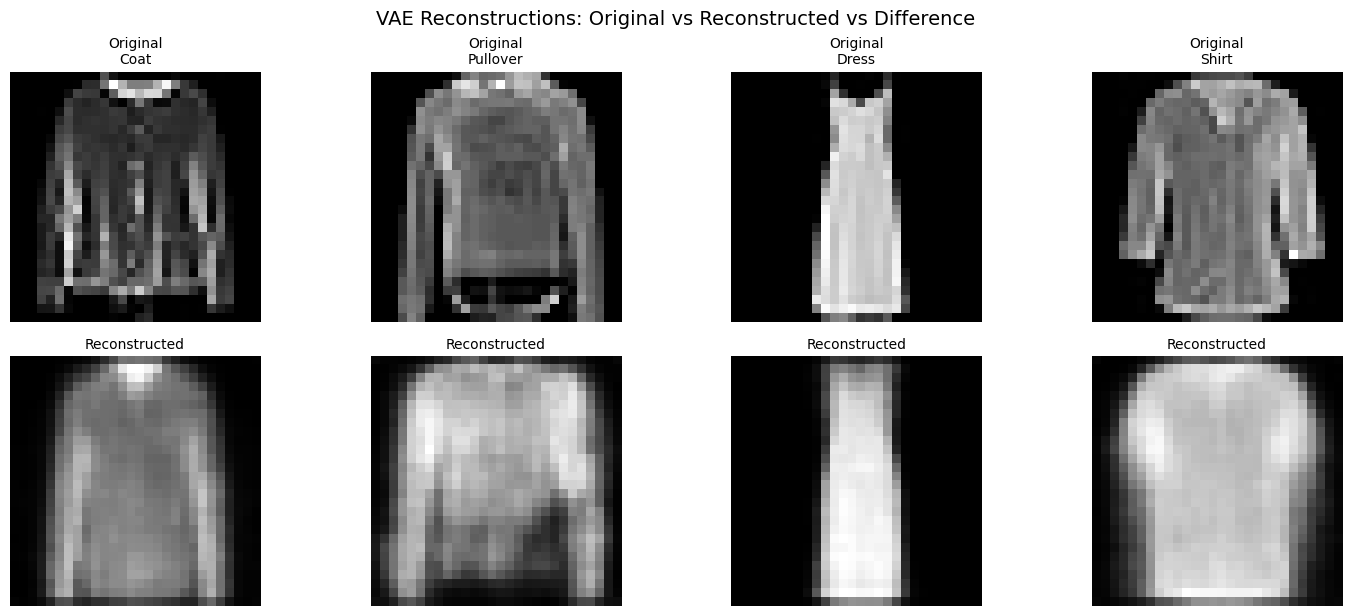

In [11]:
# Visualization functions for VAE reconstructions
def visualize_reconstructions(vae, test_loader, device, num_examples=10, figsize=(15, 6)):
    """
    Visualize original vs reconstructed images from test set

    Args:
        vae: Trained VAE model
        test_loader: Test data loader
        device: Device (cuda/cpu)
        num_examples: Number of examples to show
        figsize: Figure size for plotting
    """
    vae.eval()

    # Get a batch of test data
    with torch.no_grad():
        data_iter = iter(test_loader)
        images, labels = next(data_iter)

        # Select random examples
        indices = torch.randperm(len(images))[:num_examples]
        selected_images = images[indices].to(device)
        selected_labels = labels[indices]

        # Forward pass through VAE
        reconstructed, mu, logvar = vae(selected_images)

        # Plot original vs reconstructed
        fig, axes = plt.subplots(2, num_examples, figsize=figsize)

        # Fashion-MNIST class names
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

        for i in range(num_examples):
            # Original image
            axes[0, i].imshow(selected_images[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Original\n{class_names[selected_labels[i]]}', fontsize=10)
            axes[0, i].axis('off')

            # Reconstructed image
            axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title('Reconstructed', fontsize=10)
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.suptitle('VAE Reconstructions: Original vs Reconstructed vs Difference',
                     fontsize=14, y=1.02)
        plt.show()

visualize_reconstructions(vae, test_loader, device, num_examples=4)

Sampling $z$ ~ $p(z)$

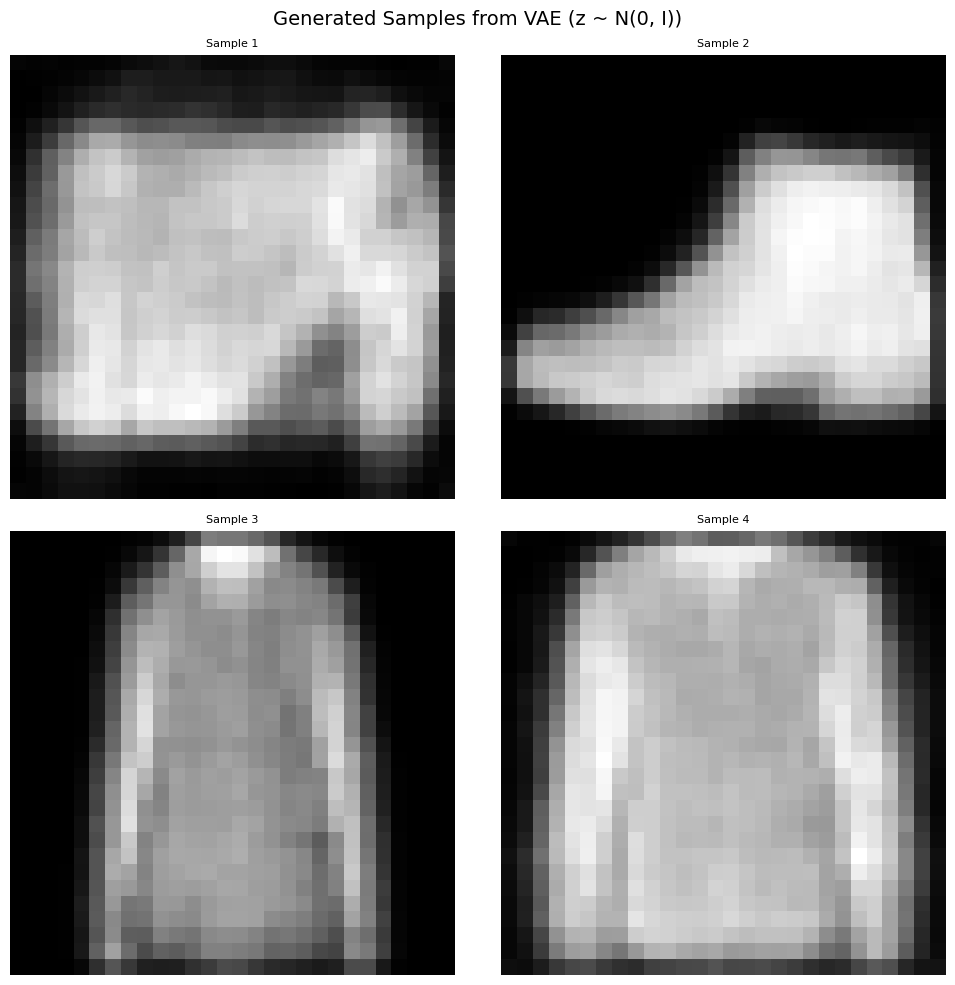

In [15]:
# Generation functions for VAE
def generate_samples(vae, device, num_samples=16, latent_dim=20):
    """
    Generate new samples by sampling from prior p(z) = N(0, I)

    Args:
        vae: Trained VAE model
        device: Device (cuda/cpu)
        num_samples: Number of samples to generate
        latent_dim: Dimension of latent space
    """
    vae.eval()

    with torch.no_grad():
        # Sample from standard normal distribution p(z) = N(0, I)
        z = torch.randn(num_samples, latent_dim).to(device)

        # Decode samples to image space
        if hasattr(vae, 'decode'):
            generated = vae.decode(z)
        else:
            # If no decode method, use decoder part of forward pass
            generated = vae.decoder(z)

        # Plot generated samples in a grid
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

        for i in range(num_samples):
            row, col = i // grid_size, i % grid_size
            axes[row, col].imshow(generated[i].cpu().squeeze(), cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Sample {i+1}', fontsize=8)

        plt.suptitle('Generated Samples from VAE (z ~ N(0, I))', fontsize=14)
        plt.tight_layout()
        plt.show()

        return generated

LATENT_DIM = 20
generated = generate_samples(vae, device, num_samples=4, latent_dim=LATENT_DIM)


Sampling from Laplacian

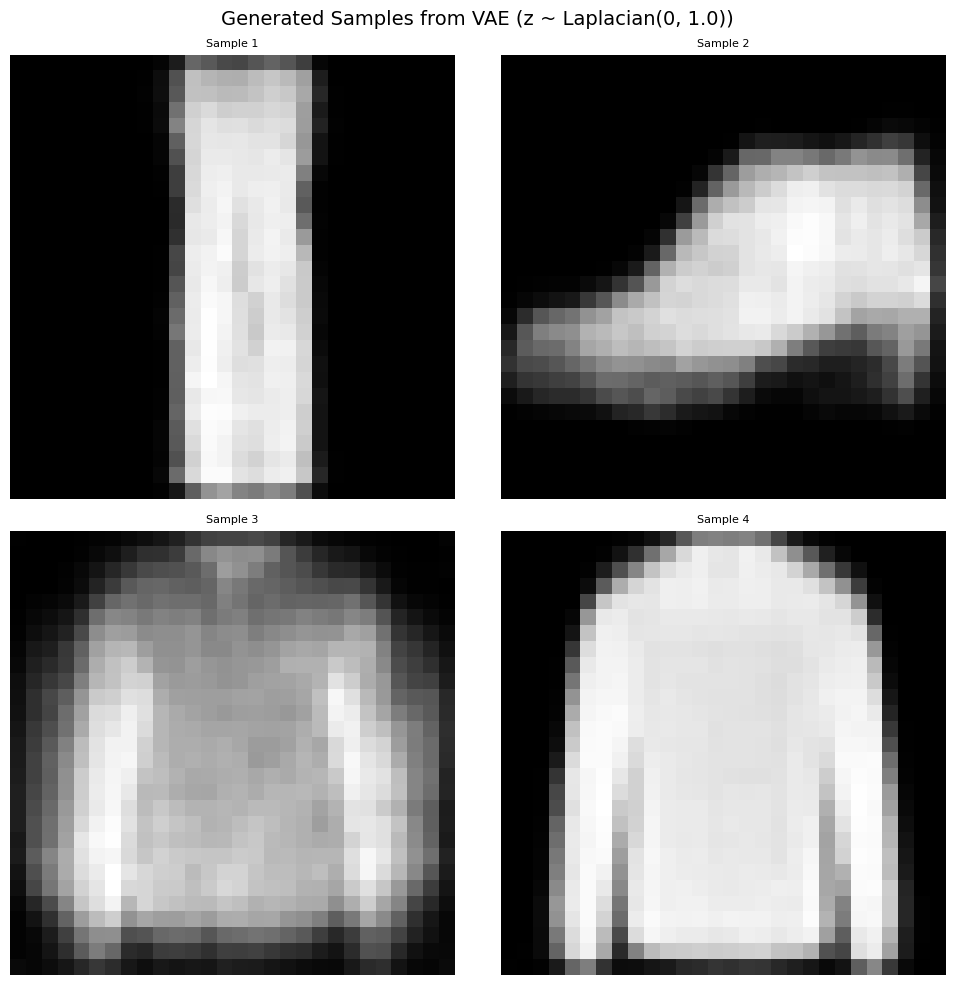

In [16]:
def sample_laplacian(size, loc=0.0, scale=1.0, device='cuda'):
    """
    Sample from Laplacian distribution using inverse transform sampling

    Args:
        size: Shape of samples to generate
        loc: Location parameter (mean)
        scale: Scale parameter (controls spread)
        device: Device to generate samples on
    """
    # Generate uniform random samples
    u = torch.rand(size, device=device)

    # Apply inverse transform sampling for Laplacian
    # F^(-1)(u) = loc - scale * sign(u - 0.5) * log(1 - 2|u - 0.5|)
    laplacian_samples = loc - scale * torch.sign(u - 0.5) * torch.log(1 - 2 * torch.abs(u - 0.5))

    return laplacian_samples

def generate_samples_laplacian(vae, device, num_samples=16, latent_dim=20, scale=1.0):
    """
    Generate samples using Laplacian prior instead of Gaussian
    """
    vae.eval()

    with torch.no_grad():
        # Sample from Laplacian distribution
        z = sample_laplacian((num_samples, latent_dim), loc=0.0, scale=scale, device=device)

        # Decode samples to image space
        if hasattr(vae, 'decode'):
            generated = vae.decode(z)
        else:
            generated = vae.decoder(z)

        # Plot generated samples in a grid
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

        for i in range(num_samples):
            row, col = i // grid_size, i % grid_size
            axes[row, col].imshow(generated[i].cpu().squeeze(), cmap='gray')
            axes[row, col].axis('off')
            axes[row, col].set_title(f'Sample {i+1}', fontsize=8)

        plt.suptitle(f'Generated Samples from VAE (z ~ Laplacian(0, {scale}))', fontsize=14)
        plt.tight_layout()
        plt.show()

        return generated


generated_laplacian = generate_samples_laplacian(vae, device, num_samples=4, latent_dim=LATENT_DIM, scale=1.0)

Gaussian vs Laplacian

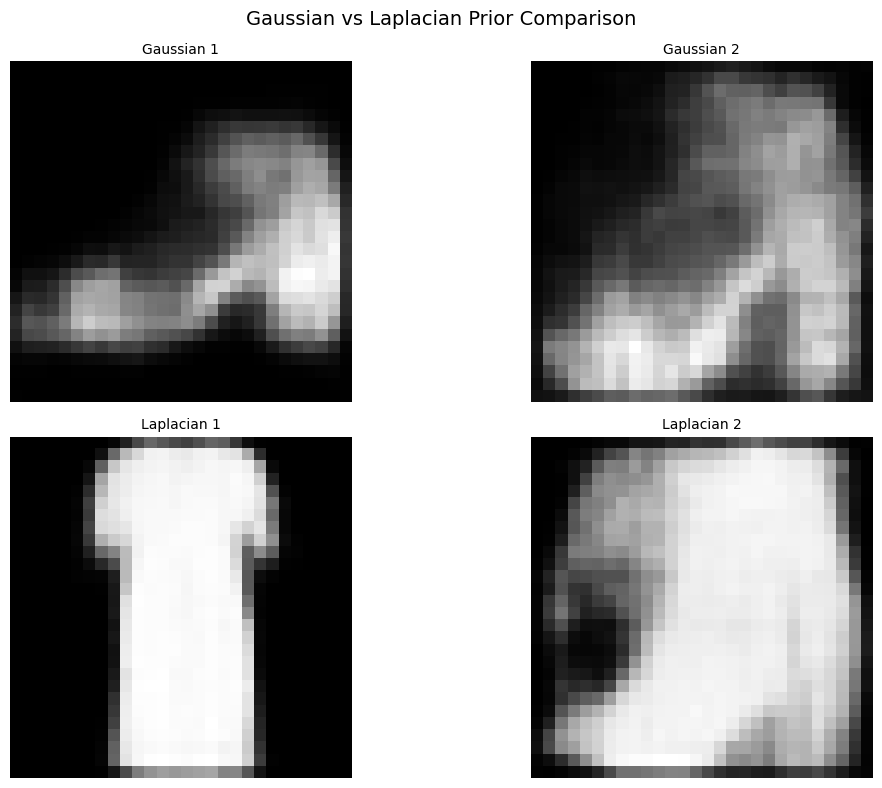

In [17]:
def compare_gaussian_vs_laplacian(vae, device, num_samples=16, latent_dim=20):
    """
    Compare generations from Gaussian vs Laplacian priors
    """
    vae.eval()

    with torch.no_grad():
        # Sample from Gaussian
        z_gaussian = torch.randn(num_samples, latent_dim).to(device)

        # Sample from Laplacian
        z_laplacian = sample_laplacian((num_samples, latent_dim), scale=1.0, device=device)

        # Generate images from both
        if hasattr(vae, 'decode'):
            generated_gaussian = vae.decode(z_gaussian)
            generated_laplacian = vae.decode(z_laplacian)
        else:
            generated_gaussian = vae.decoder(z_gaussian)
            generated_laplacian = vae.decoder(z_laplacian)

        # Plot comparison
        grid_size = int(np.sqrt(num_samples))
        fig, axes = plt.subplots(2, grid_size, figsize=(12, 8))

        for i in range(grid_size):
            # Gaussian samples
            axes[0, i].imshow(generated_gaussian[i].cpu().squeeze(), cmap='gray')
            axes[0, i].set_title(f'Gaussian {i+1}', fontsize=10)
            axes[0, i].axis('off')

            # Laplacian samples
            axes[1, i].imshow(generated_laplacian[i].cpu().squeeze(), cmap='gray')
            axes[1, i].set_title(f'Laplacian {i+1}', fontsize=10)
            axes[1, i].axis('off')

        plt.suptitle('Gaussian vs Laplacian Prior Comparison', fontsize=14)
        plt.tight_layout()
        plt.show()

compare_gaussian_vs_laplacian(vae, device, num_samples=4, latent_dim=LATENT_DIM)

## Posterior Collapse Investigation

## Mitigating Posterior Collapse

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)

EPOCHS = 10
LR = 1e-3
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)
BETA = 10.0

In [18]:
train_losses = []
val_losses = []

for epoch in range(1,EPOCHS+1):
    train_loss, train_recon_loss, train_kld_loss = train_epoch(vae, train_loader, optimizer, device, BETA)
    val_loss, val_recon_loss, val_kld_loss = validate(vae, test_loader, device, BETA)
    train_losses.append((epoch,train_loss, train_recon_loss, train_kld_loss))
    val_losses.append((epoch,val_loss, val_recon_loss, val_kld_loss))
    print(f"Epoch [{epoch}/{EPOCHS}]")
    print(f"\tTotal Train Loss: {train_loss:.4f} | KL Loss: {train_kld_loss:.4f} | Recon Loss: {train_recon_loss:.4f}")
    print(f"\tTotal Val Loss: {val_loss:.4f} | KL Loss: {val_kld_loss:.4f} | Recon Loss: {val_recon_loss:.4f}")

Epoch [1/10]
	Total Train Loss: 30.0501 | KL Loss: 5.1146 | Recon Loss: 19.8209
	Total Val Loss: 30.0374 | KL Loss: 4.9119 | Recon Loss: 20.2137


Epoch [2/10]
	Total Train Loss: 30.0487 | KL Loss: 5.1444 | Recon Loss: 19.7599
	Total Val Loss: 30.2178 | KL Loss: 4.9338 | Recon Loss: 20.3502


Epoch [3/10]
	Total Train Loss: 29.9823 | KL Loss: 5.1334 | Recon Loss: 19.7155
	Total Val Loss: 29.8940 | KL Loss: 4.9245 | Recon Loss: 20.0451


Epoch [4/10]
	Total Train Loss: 29.9562 | KL Loss: 5.1594 | Recon Loss: 19.6375
	Total Val Loss: 30.0377 | KL Loss: 5.0216 | Recon Loss: 19.9946


Epoch [5/10]
	Total Train Loss: 29.9073 | KL Loss: 5.1529 | Recon Loss: 19.6015
	Total Val Loss: 30.1761 | KL Loss: 5.3801 | Recon Loss: 19.4160


Epoch [6/10]
	Total Train Loss: 29.8807 | KL Loss: 5.1670 | Recon Loss: 19.5467
	Total Val Loss: 29.9504 | KL Loss: 5.1852 | Recon Loss: 19.5799


Epoch [7/10]
	Total Train Loss: 29.8307 | KL Loss: 5.1566 | Recon Loss: 19.5176
	Total Val Loss: 29.8398 | KL Loss: 5.1747 | Recon Loss: 19.4903


Epoch [8/10]
	Total Train Loss: 29.8435 | KL Loss: 5.1882 | Recon Loss: 19.4671
	Total Val Loss: 29.7986 | KL Loss: 5.1439 | Recon Loss: 19.5109


Epoch [9/10]
	Total Train Loss: 29.7871 | KL Loss: 5.1884 | Recon Loss: 19.4103
	Total Val Loss: 29.7893 | KL Loss: 5.1889 | Recon Loss: 19.4115


Epoch [10/10]
	Total Train Loss: 29.7808 | KL Loss: 5.1889 | Recon Loss: 19.4030
	Total Val Loss: 29.9580 | KL Loss: 5.3197 | Recon Loss: 19.3186


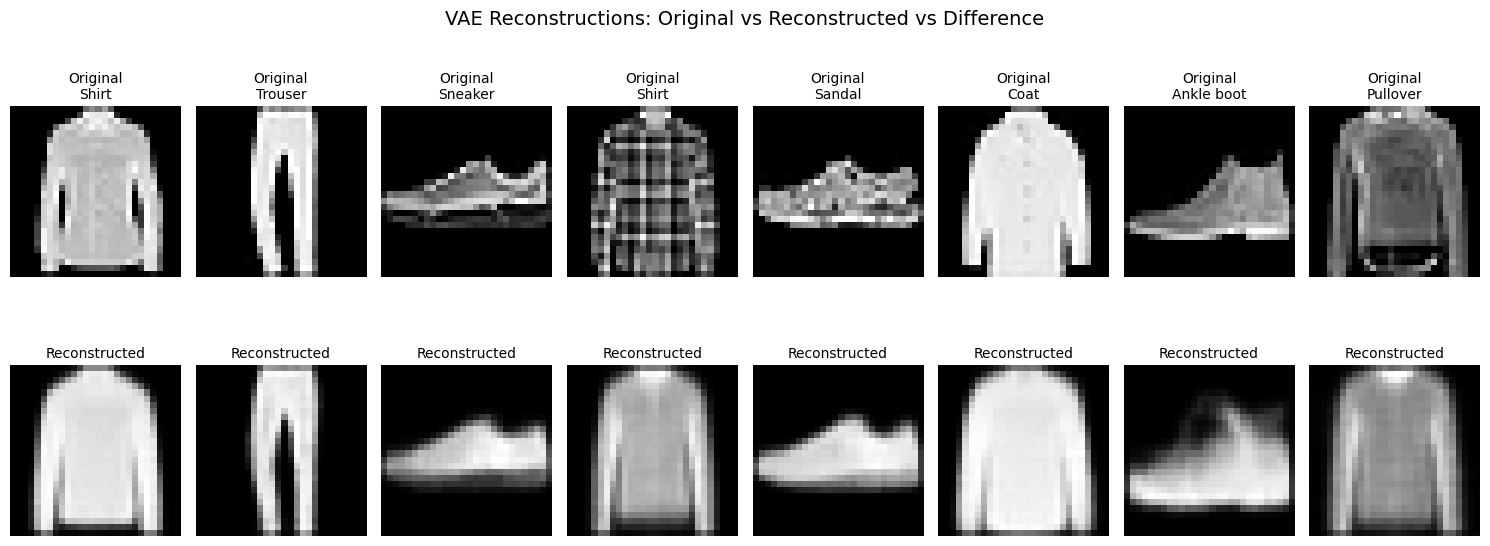

In [19]:
visualize_reconstructions(vae, test_loader, device, num_examples=8)

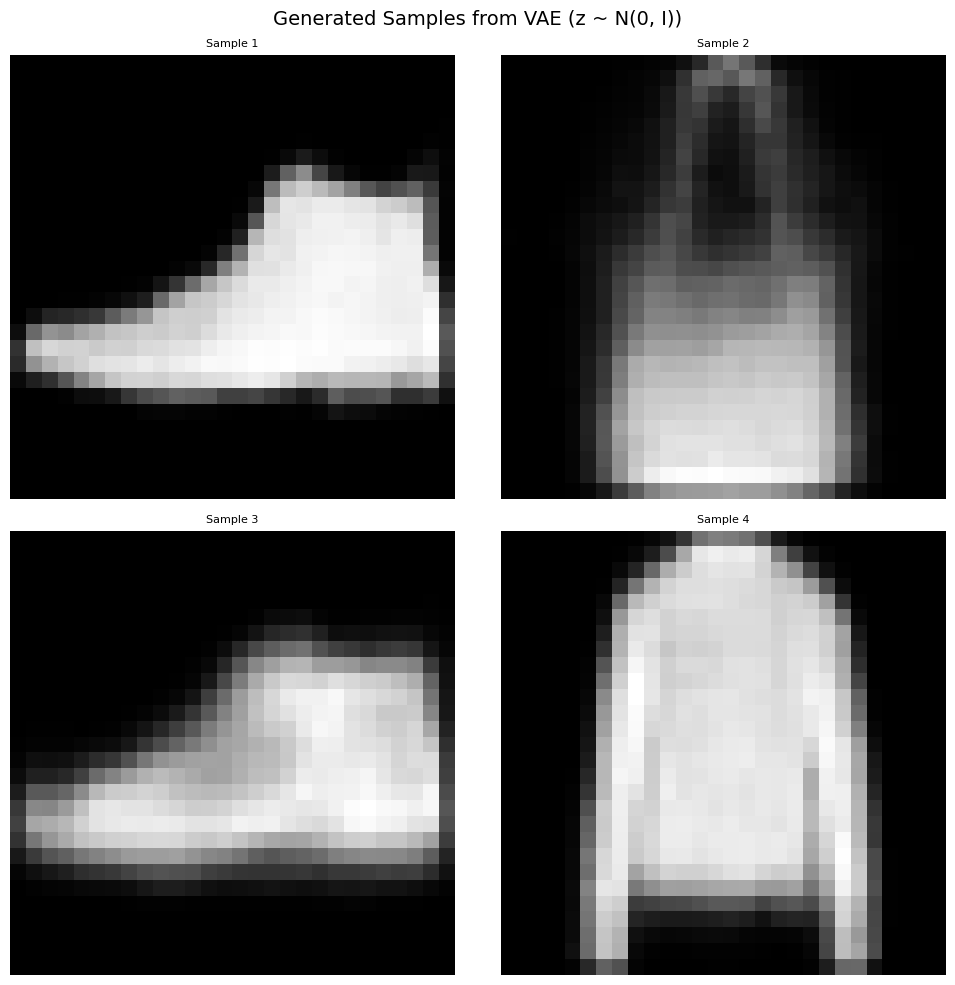

In [26]:
samples_g = generate_samples(vae, device, num_samples=4, latent_dim=LATENT_DIM)

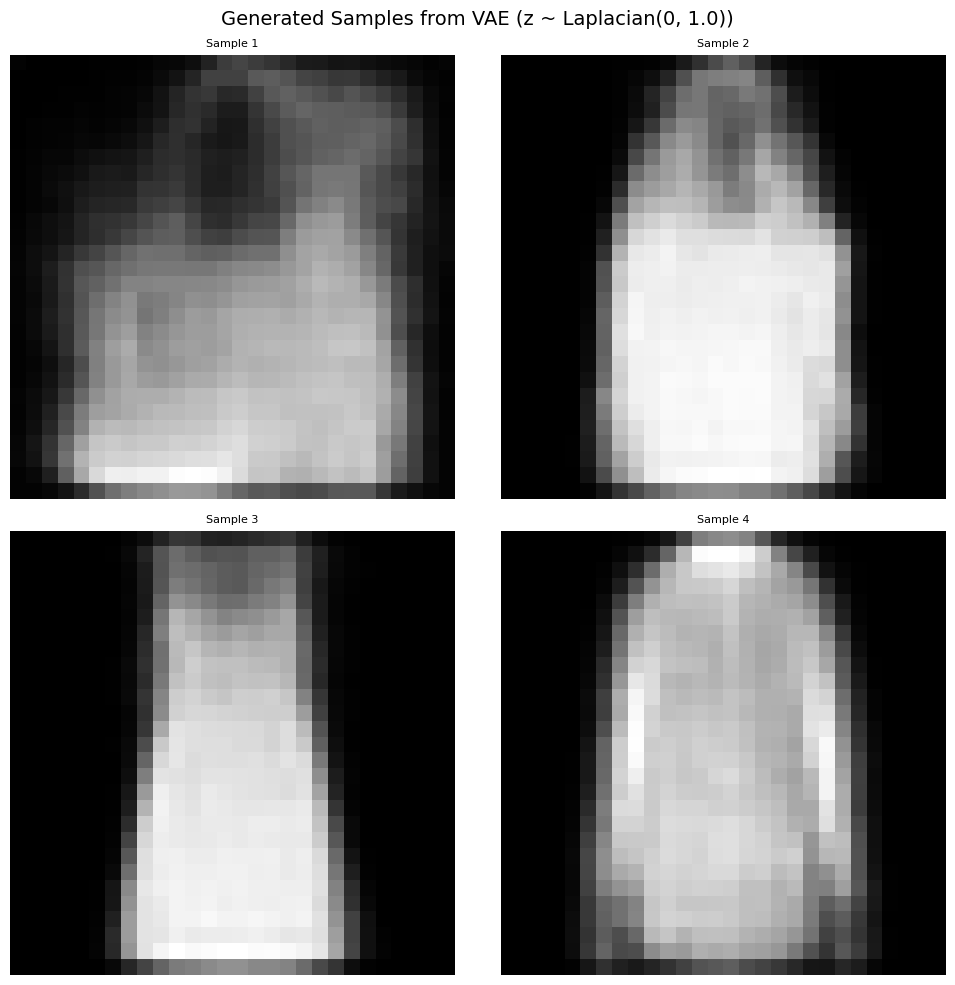

In [28]:
samples_l = generate_samples_laplacian(vae, device, num_samples=4, latent_dim=LATENT_DIM, scale=1.0)

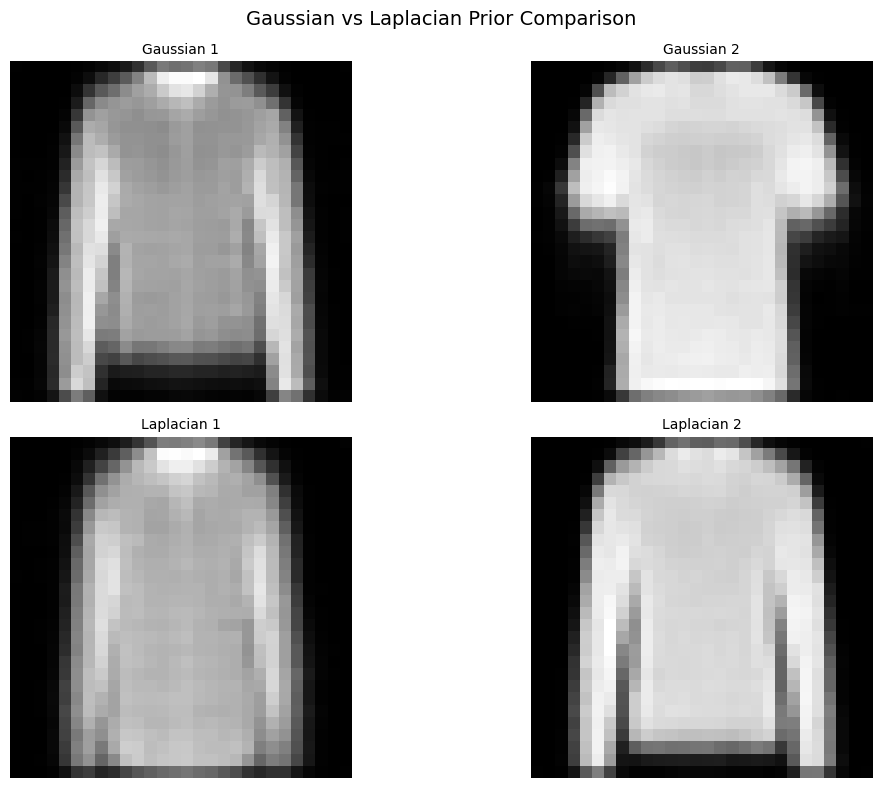

In [29]:
compare_gaussian_vs_laplacian(vae, device, num_samples=4, latent_dim=LATENT_DIM)